# Mitigating Bias with AIF360


### Loading and preparing the dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#pd.options.mode.chained_assignment = None

In [4]:
df = pd.read_csv("heart_disease.csv")
df.head(10)

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
4,4,57,female,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,yes
5,5,57,male,0,140.0,192.0,0,1,148.0,0,0.4,1,0,1,yes
6,6,56,female,1,140.0,294.0,0,0,153.0,0,1.3,1,0,2,yes
7,7,44,male,1,120.0,263.0,0,1,173.0,0,0.0,2,0,3,yes
8,8,52,male,2,172.0,199.0,1,1,162.0,0,0.5,2,0,3,yes
9,9,57,male,2,150.0,168.0,0,1,174.0,0,1.6,2,0,2,yes


(303, 15)

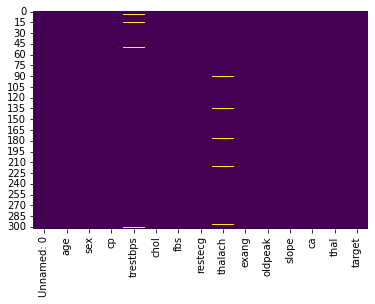

In [5]:
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')
df.shape

<AxesSubplot:>

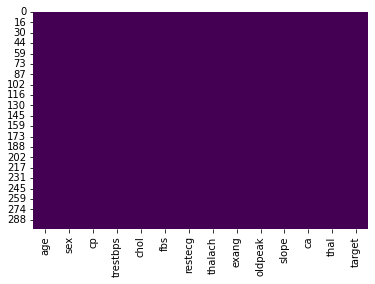

In [6]:
df = df.dropna(how='any', axis = 0)
df = df.drop(['Unnamed: 0'], axis = 1)
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [7]:
target_counts = df['target'].value_counts()
target_counts

yes    160
no     133
Name: target, dtype: int64

[Text(0, 0, '202'), Text(0, 0, '91')]

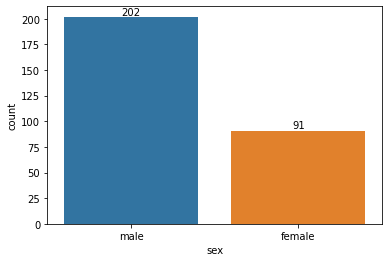

In [8]:
df1 = sns.countplot(x='sex', data = df)
df1.bar_label(df1.containers[0])

[Text(0, 0, '160'), Text(0, 0, '133')]

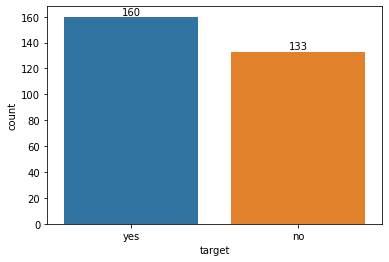

In [9]:
df1 = sns.countplot(x='target', data = df)
df1.bar_label(df1.containers[0])

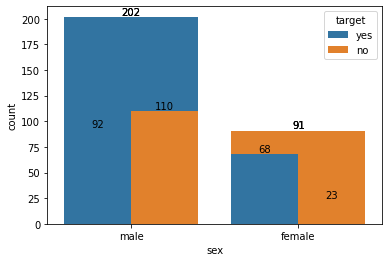

In [10]:
df1 = sns.countplot(x=df['sex'])
df1.bar_label(df1.containers[0])
df2 = sns.countplot(x=df['sex'],hue=df['target'])
df2.bar_label(df2.containers[0])
for container in df2.containers:
    df2.bar_label(container)

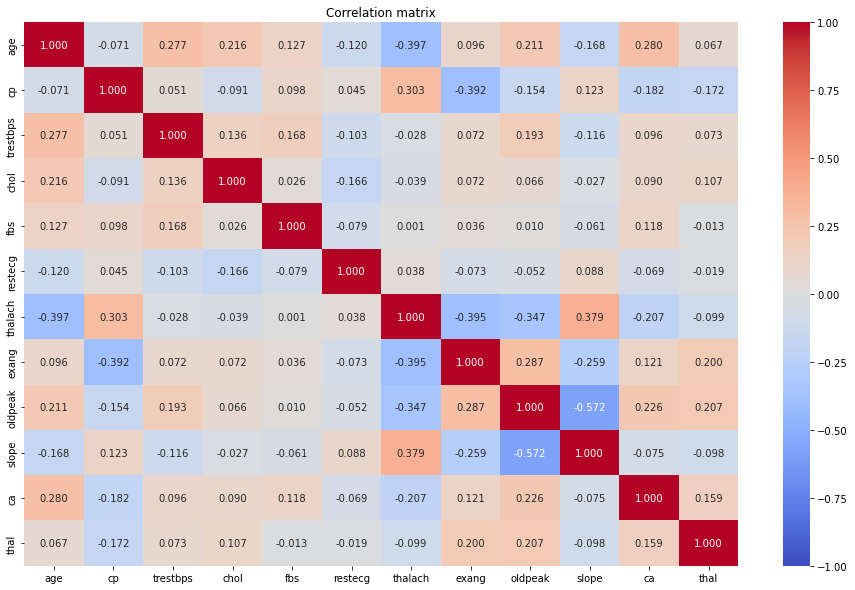

In [11]:
df1 = df.copy()
from sklearn.preprocessing import LabelEncoder
cols = df1.columns

def encode_df(dataframe):
    le = LabelEncoder()
    for col in dataframe.columns:
        dataframe[col] = le.fit_transform(dataframe[col])
    return dataframe

fig,ax = plt.subplots(figsize=(16,10))
sns.heatmap(df1.corr(), annot=True, fmt='.3f', vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=ax)

plt.title('Correlation matrix')
plt.show()

In [12]:
#Encode data
df_encoded = encode_df(df)
df_encoded.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29,1,3,31,62,1,0,47,0,22,0,0,1,1
1,3,1,2,22,78,0,1,82,0,32,0,0,2,1
2,7,0,1,22,33,0,0,69,0,14,2,0,2,1
3,22,1,1,14,65,0,1,74,0,8,2,0,2,1
5,23,1,0,28,23,0,1,45,0,4,1,0,1,1


In [13]:
#Separate target variable
df = df_encoded.copy()
x = df.drop(['target'], axis = 1)
y = df['target']

In [14]:
#Scale data
scaler = StandardScaler()
data_std = scaler.fit_transform(x)

In [15]:
#Split data
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.22, random_state = 0)

### PREPROCESSING- Calculating actual disparate impact on testing values from original dataset
Disparate Impact is defined as the ratio of favorable outcomes for the unprivileged group divided by the ratio of favorable outcomes for the privileged group. It is a Preprocessing technique used to mitigate bias in training data that edits feature values increase group fairness while preserving rank-ordering within groups.
The acceptable threshold is between .8 and 1.25, with .8 favoring the privileged group, and 1.25 favoring the unprivileged group.

In [16]:
Disparate_test = x_test.copy()
Disparate_test['target_Actual'] = y_test
Disparate_test.shape

(65, 14)

In [17]:
# Privileged group: Males (1)
# Unprivileged group: Females (0)
male_df1 = Disparate_test[Disparate_test['sex'] == 1]
num_of_privileged1 = male_df1.shape[0]
female_df1 = Disparate_test[Disparate_test['sex'] == 0]
num_of_unprivileged1 = female_df1.shape[0]

In [18]:
unprivileged_outcomes1 = female_df1[female_df1['target_Actual'] == 1].shape[0]
unprivileged_ratio1 = unprivileged_outcomes1/num_of_unprivileged1
unprivileged_ratio1

0.6666666666666666

In [19]:
privileged_outcomes1 = male_df1[male_df1['target_Actual'] == 1].shape[0]
privileged_ratio1 = privileged_outcomes1/num_of_privileged1
privileged_ratio1

0.36363636363636365

In [20]:
# Calculating disparate impact
disparate_impact = unprivileged_ratio1 / privileged_ratio1
print("Disparate Impact, Sex vs. Predicted target Status: " + str(disparate_impact))

Disparate Impact, Sex vs. Predicted target Status: 1.8333333333333333


### Arrived at a disparate income ratio of 1.8. This indicates that the actual test split favors the privileged group (males), as a disparate income ratio of 1 indicates complete equality.


In [21]:
#Logistic Regression with bias
model = LogisticRegression(max_iter = 1000)
logreg1 = model.fit(x_train, y_train)
print("Train set score of LogisticRegression: {:.3f}".format(logreg1.score(x_train, y_train)))
print("Test set score of LogisticRegression: {:.3f}".format(logreg1.score(x_test, y_test)))

Train set score of LogisticRegression: 0.860
Test set score of LogisticRegression: 0.815


# Mitigating Bias with AI Fairness 360

Bias mitigation algorithms can be generally categorized into three categories: pre-process (which affects the data, prior to training), in-process (which affects the classifier itself), and post-process (which affects the prediction labels that are output). The algorithm used here is DisparateImpactRemover, which edits feature values to increase group fairness. It uses BinaryLabelDataSet to convert Pandas dataframe.

In [558]:
binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['target'],
    protected_attribute_names=['sex'])
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed_Disparate = dataset_transf_train.convert_to_dataframe()[0]
transformed_Disparate

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29.0,1.0,3.0,31.0,62.0,1.0,0.0,45.0,0.0,15.0,0.0,0.0,1.0,1.0
1,3.0,1.0,2.0,22.0,78.0,0.0,1.0,72.0,0.0,28.0,0.0,0.0,2.0,1.0
2,4.0,0.0,1.0,21.0,26.0,0.0,0.0,69.0,0.0,14.0,2.0,0.0,2.0,1.0
3,22.0,1.0,1.0,13.0,65.0,0.0,1.0,67.0,0.0,6.0,2.0,0.0,2.0,1.0
5,23.0,1.0,0.0,27.0,23.0,0.0,1.0,45.0,0.0,3.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,27.0,0.0,0.0,17.0,19.0,0.0,1.0,25.0,1.0,0.0,1.0,0.0,2.0,0.0
298,21.0,0.0,0.0,28.0,58.0,0.0,1.0,15.0,1.0,2.0,1.0,0.0,3.0,0.0
299,11.0,1.0,3.0,7.0,90.0,0.0,1.0,30.0,0.0,8.0,1.0,0.0,3.0,0.0
300,34.0,1.0,0.0,29.0,23.0,1.0,1.0,37.0,0.0,26.0,1.0,2.0,3.0,0.0


### Train a model using the dataset that underwent the pre-processing

In [588]:
x_trans = transformed_Disparate.drop(['target'], axis = 1)
y_trans = transformed_Disparate['target']
scaler = StandardScaler()
data_std = scaler.fit_transform(x_trans)
x_trans_train,x_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y_trans, test_size=0.20, random_state = 0)

In [589]:
#Logistic Regression on transformed data
logreg2 = model.fit(x_trans_train, y_trans_train)
print("Train set score of LogisticRegression: {:.3f}".format(logreg2.score(x_trans_train, y_trans_train)))
print("Test set score of LogisticRegression: {:.3f}".format(logreg2.score(x_trans_test, y_trans_test)))

Train set score of LogisticRegression: 0.863
Test set score of LogisticRegression: 0.831


### Calculating disparate impact on predicted values by model trained on transformed dataset

In [590]:
#Add the array into x_test as a column for when we calculate the fairness metrics.
y_trans_pred = model.predict(x_trans_test)
x_trans_test['target_Predicted'] = y_trans_pred
transformed_output = x_trans_test

Disparate Impact is defined as the ratio of favorable outcomes for the unpriviliged group divided by the ratio of favorable outcomes for the priviliged group. The acceptable threshold is between .8 and 1.25, with .8 favoring the priviliged group, and 1.25 favoring the unpriviliged group.

In [591]:
# Privileged group: Males (1)
# Unprivileged group: Females (0)
male_df2 = transformed_output[transformed_output['sex'] == 1]
num_of_privileged2 = male_df2.shape[0]
female_df2 = transformed_output[transformed_output['sex'] == 0]
num_of_unprivileged2 = female_df2.shape[0]

In [592]:
unprivileged_outcomes2 = female_df2[female_df2['target_Predicted'] == 1].shape[0]
unprivileged_ratio2 = unprivileged_outcomes2/num_of_unprivileged2
unprivileged_ratio2

0.65

In [593]:
privileged_outcomes2 = male_df2[male_df2['target_Predicted'] == 1].shape[0]
privileged_ratio2 = privileged_outcomes2/num_of_privileged2
privileged_ratio2

0.5128205128205128

In [594]:
# Calculating disparate impact
disparate_impact = unprivileged_ratio2 / privileged_ratio2
print("Disparate Impact, Sex vs. Predicted target Status: " + str(disparate_impact))

Disparate Impact, Sex vs. Predicted target Status: 1.2675


In [587]:
#Reduced gender bias from 1.81 to 1.27